In [1]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import csv
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot

In [2]:
#Config window, so set all your configurations here
# N_Steps_In je input rolling window, N_Steps_Out je output rolling window (tj forecast period, ali continuos)
# Treba paziti ovdje za data leaking, i double forecasting da se ne desi
n_steps_in, n_steps_out = 5, 2

#Training, validation and testing
testing 

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [9]:
#Full data loading and preprocessing
# load dataset
dataset = read_csv('CSV Files with Calculated Indicators/NYSE.csv', header=0, index_col=None)

# Shifted target kolona
dataset['Adj Close_Shifted'] = dataset['Adj Close'].shift(periods=-n_steps_out)

dataset = dataset.iloc[:-n_steps_out]

# Convert Date column to date, but in this case Date is index column
dataset['Date'] = pd.to_datetime(dataset['Date'], origin='1900-01-01', unit='D')

timestamps = dataset['Date']

dataset = dataset.drop('Date', axis=1)

#Exported values
values = dataset.values

#CT column is a class, not a continous variable, so we get the index, and do some magic with it idk
ct_index = dataset.columns.get_loc("CT")

# integer encode direction
encoder = LabelEncoder()
values[:,ct_index] = encoder.fit_transform(values[:,ct_index])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

X, y = split_sequences(scaled, n_steps_in, n_steps_out)
n_features = X.shape[2] #Broj kolona
print('This is X[0]')
print(X[0])
print('This is y[0]') #Y je set odgovora, svaki row je zapravo serija odgovora.
print(y[0])
print(n_features)

This is X[0]
[[1.28013432e-01 1.20803803e-01 1.31644994e-01 1.28013432e-01
  1.28013432e-01 1.10185415e-01 1.20744705e-01 1.11874104e-01
  9.64013040e-02 8.77089202e-02 1.03212267e-01 1.16501182e-01
  1.28875941e-01 1.18024439e-01 1.08373106e-01 9.79183316e-02
  9.74815190e-02 9.99446213e-02 1.08741969e-01 1.22722358e-01
  7.73936272e-01 2.26668213e-02 2.24522986e-02 4.75055128e-02
  1.14966137e-02 1.39871225e-01 1.25338078e-01 0.00000000e+00
  4.20645475e-01 9.60974514e-01 2.78281987e-01 6.94119990e-01
  5.82727134e-01 3.05879980e-01 3.05879980e-01 4.71170455e-01
  5.62482655e-01 5.69829285e-01 5.56282043e-01 6.96672976e-01
  6.22179270e-01 4.29740906e-01 3.36001635e-01 3.21713746e-01
  5.79354525e-01 6.94692969e-01 6.53367758e-01 6.47466719e-01
  7.66093373e-01 7.03889906e-01 7.03889906e-01 4.07629430e-01
  3.81442428e-01 1.45643810e-03 2.49087084e-02 1.22758836e-01
  9.79188085e-02 1.13833509e-01 6.38400137e-01 1.92593206e-02
  5.36677003e-01 0.00000000e+00 0.00000000e+00]
 [1.26764

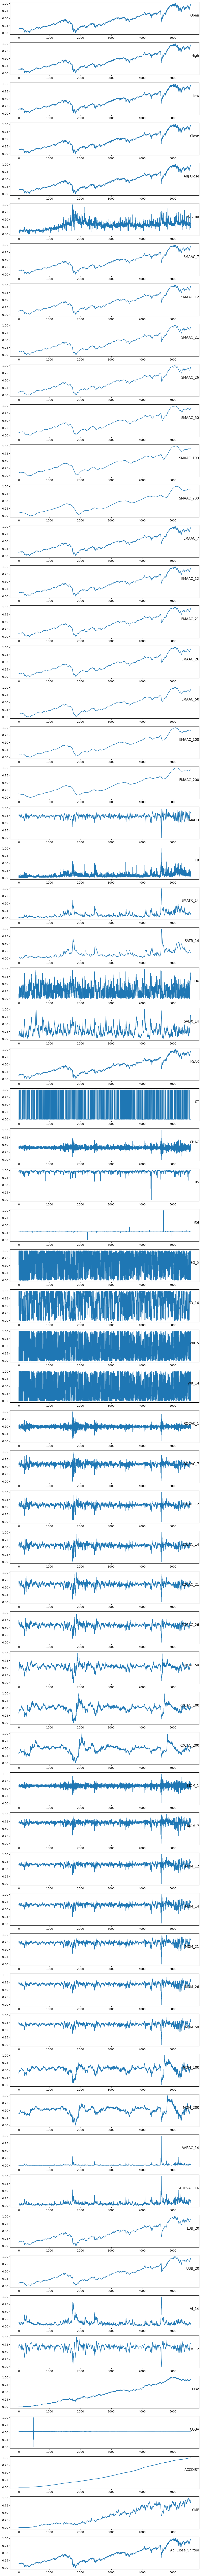

In [7]:
# Ovo je basic plotting
# Automatically determine the number of columns
num_columns = dataset.shape[1]  # This gets the number of columns in the DataFrame

pyplot.figure(figsize=(10, num_columns*2))  # Adjust the figure size as needed

# Plot each column
for i in range(num_columns):
    pyplot.subplot(num_columns, 1, i+1)  # Subplots are indexed from 1
    pyplot.plot(scaled[:, i])
    pyplot.title(dataset.columns[i], y=0.5, loc='right')

pyplot.tight_layout()  # Optional: Improves the layout
pyplot.show()

In [ ]:
#My model code



# Model Code 1
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

# Model Code 2
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
# Nemoj zaboraviti da jedan row je jedan step, a kolona je jedan feature
x_input = array([[70, 75], 
                 [80, 85], 
                 [90, 95],
                 [100, 105],
                 [105, 110],])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)